# 인과추론의 핵심 문제: 선택 편향과 오차항의 관계

**선택 편향(Selection Bias)이란?**

- **"Treatment를 받은 그룹"**이 **"만약 Treatment를 받지 않았을 경우"**의 결과(Counterfactual)와 **"실제로 Treatment를 받지 않은 그룹"**의 결과(Control Group) 간의 차이입니다.
- 이는 Treatment 여부 외에 두 그룹 사이에 존재하는 원래의, 관찰되지 않은 차이로 인해 발생합니다.

**오차항(Error Term, ε)의 역할:**
- 회귀식에서 오차항은 종속변수(y)에 영향을 미치지만, 분석에 사용된 독립변수로는 설명되지 않는 모든 요인들을 담는 바구니와 같습니다.
- 이때, 선택 편향을 일으키는 관찰되지 않은 요인들(예: 개인의 성향, 능력 등)이 모두 이 오차항에 포함됩니다.

**Treatment와 오차항의 상관관계:**

- 따라서, 선택 편향을 일으키는 요인들은 오차항에 포함됩니다.
- 그리고, 이 요인들은 Treatment를 받을지 말지를 결정하는 데도 영향을 미칩니다.
- 결론적으로, 오차항은 Treatment 변수와 독립적이지 않고 서로 상관관계를 가지게 됩니다.

**회귀분석의 한계:**

- 일반적인 회귀분석은 독립변수(Treatment)와 오차항이 서로 무관하다는 가정하에 결과를 계산합니다.

- 하지만 선택 편향이 존재하면 이 가정이 깨지므로, 회귀분석 결과(계수)가 순수한 인과관계가 아닌 왜곡된(biased) 효과를 보여주게 됩니다.

- 따라서, 독립변수와 오차항 간의 상관관계가 없어야만 회귀 분석의 결과를 인과관계로 신뢰성 있게 해석할 수 있습니다.

In [ ]:
"""
회귀식에서 관찰되지 않은 모든 변수는 error에 포함된다.
선택 편향은 관찰되지 않은 변수에 의해 나타나며 (ex.약을 먹는 습관 등) 정확한 ITE 추정에 방해가 된다.
따라서, 독립변수(Treatment)와 오차항 간의 상관관계가 없어야만 회귀 분석의 결과를 인과관계로 신뢰성 있게 해석할 수 있다.

이를 위한 방법이 도구변수(Instrumental Variable)이다.
"""

# 패키지 및 데이터 불러오기

In [ ]:
!pip install causalml

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from xgboost import XGBRegressor
import warnings

from causalml.inference.meta import BaseXRegressor, BaseDRRegressor
from causalml.inference.iv import BaseDRIVRegressor
from causalml.dataset import synthetic_data
from causalml.metrics import *

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

ERROR:duecredit:Failed to import duecredit due to No module named 'duecredit'


In [ ]:
# 데이터 생성
np.random.seed(12)
y, X, treatment, tau, b, e = synthetic_data(mode=1, n=10000, p=8, sigma=1.0)

## X Learner, DR Learner 비교

여기서 treatment_effect_learner 에는 선형회귀를 사용합니다.

왜냐하면 ITE 추정치는 종종 노이즈가 많고, 유연한 추정치를 사용하면 과적합될 가능성이 있기 때문입니다.

In [ ]:
learner_x = BaseXRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y)

In [ ]:
learner_dr = BaseDRRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_dr = learner_dr.fit_predict(X=X, treatment=treatment, y=y)

Text(0.5, 1.0, 'DR Learner')

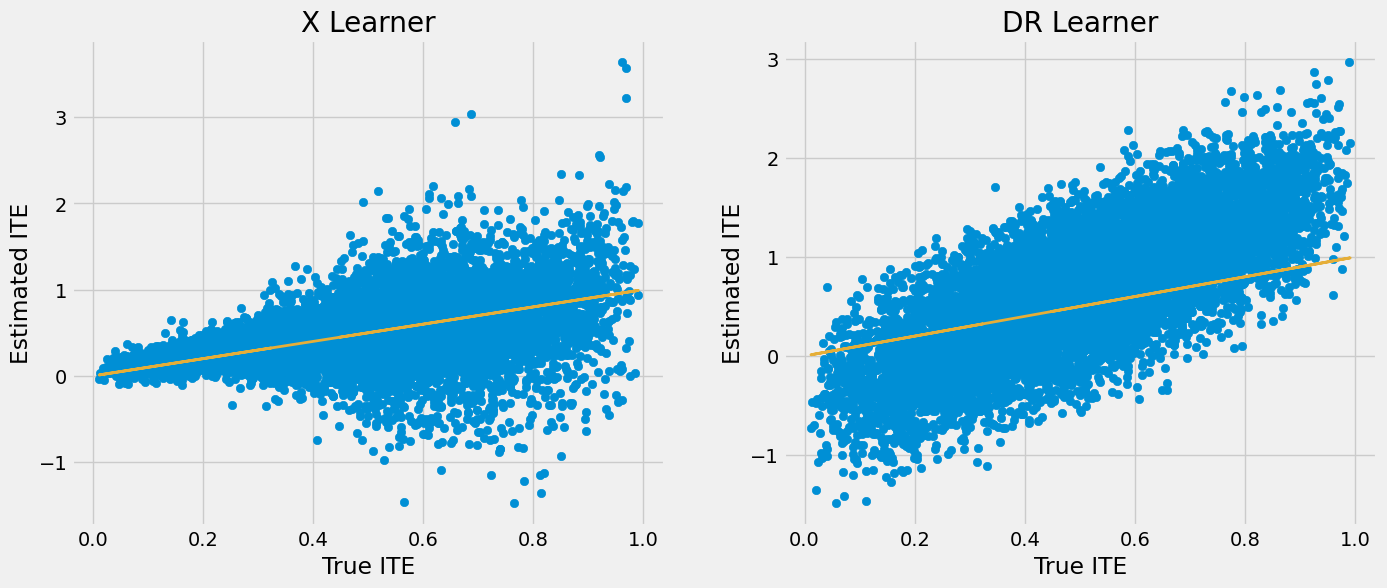

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].scatter(tau, cate_x)
ax[0].plot(tau, tau, color='C2', linewidth=2)
ax[0].set_xlabel('True ITE')
ax[0].set_ylabel('Estimated ITE')
ax[0].set_title('X Learner')
ax[1].scatter(tau, cate_dr)
ax[1].plot(tau, tau, color='C2', linewidth=2)
ax[1].set_xlabel('True ITE')
ax[1].set_ylabel('Estimated ITE')
ax[1].set_title('DR Learner')

## 잔차와 Treatment 사이의 상관관계 확인 = 0.23

In [ ]:
y_pred_treated = learner_x.models_tau_t[1].predict(X[treatment==1])   # treated group 예측값
y_pred_control = learner_x.models_tau_c[1].predict(X[treatment==0])   # control group 예측값

# 실제 y
y_treated = y[treatment==1]
y_control = y[treatment==0]

# 잔차
residuals_treated = y_treated - y_pred_treated
residuals_control = y_control - y_pred_control

residuals = np.concat([residuals_treated, residuals_control])
treatment_reorderd = np.concat([treatment[treatment==1], treatment[treatment==0]])

np.corrcoef(treatment_reorderd, residuals) # 0.23

array([[1.        , 0.22970739],
       [0.22970739, 1.        ]])

## 과적합 예시

Text(0.5, 1.0, 'DR Learner')

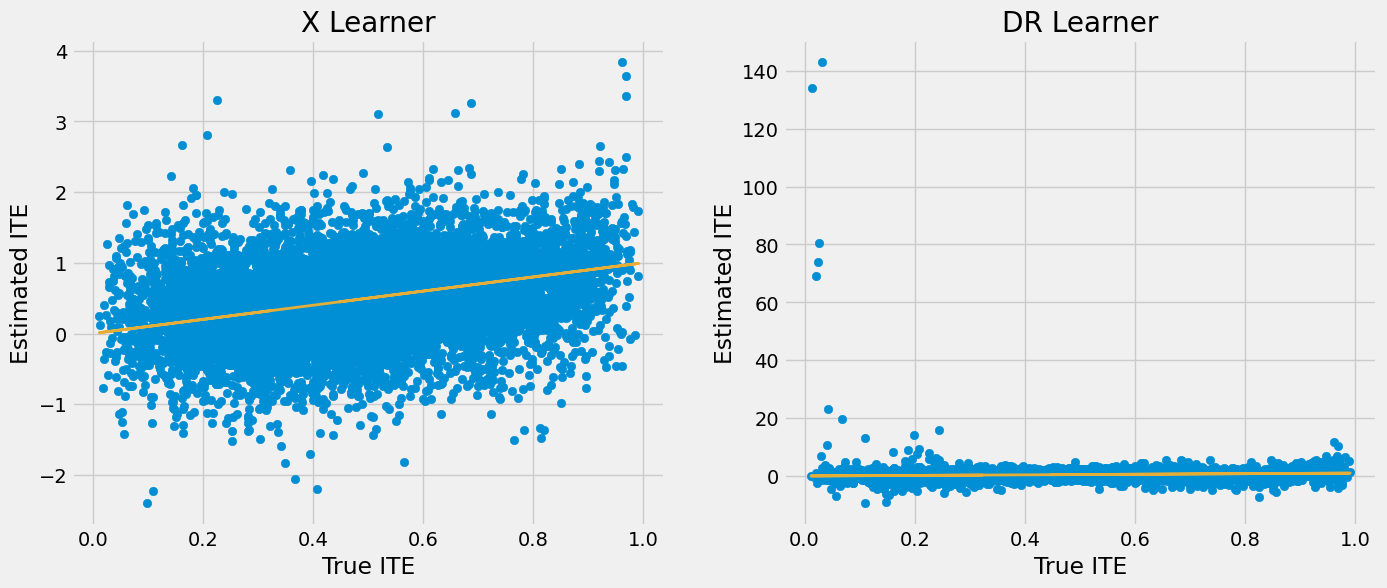

In [ ]:
learner_x = BaseXRegressor(learner=XGBRegressor())
cate_x = learner_x.fit_predict(X=X, treatment=treatment, y=y)
learner_dr = BaseDRRegressor(learner=XGBRegressor())
cate_dr = learner_dr.fit_predict(X=X, treatment=treatment, y=y)

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].scatter(tau, cate_x)
ax[0].plot(tau, tau, color='C2', linewidth=2)
ax[0].set_xlabel('True ITE')
ax[0].set_ylabel('Estimated ITE')
ax[0].set_title('X Learner')
ax[1].scatter(tau, cate_dr)
ax[1].plot(tau, tau, color='C2', linewidth=2)
ax[1].set_xlabel('True ITE')
ax[1].set_ylabel('Estimated ITE')
ax[1].set_title('DR Learner')

# 숨겨진 교란 변수가 있는 합성 데이터 (hidden confounder)

합성 데이터를 생성하는 과정에서 e(성향점수)와 y에 X1 이 영향을 미치고 있습니다.

따라서, X1을 메타러너에게 주지 않는다면, hidden confounder가 됩니다.


In [ ]:
np.random.seed(1)
n = 10000
p = 8
sigma = 1.0
error = np.random.normal(size=n)

# eta = 0.1
# X = np.random.uniform(size=n*p).reshape((n, -1))
# b = np.sin(np.pi * X[:, 0] * X[:, 1]) + 2 * (X[:, 2] - 0.5) ** 2 + X[:, 3] + 0.5 * X[:, 4]
# e = np.maximum(np.repeat(eta, n), np.minimum(np.sin(np.pi * X[:, 0] * X[:, 1]), np.repeat(1-eta, n))) # 성향점수
# tau = (X[:, 0] + X[:, 1]) / 2

# 도구변수 사용
# 선택 편향에 의해 iTE를 추정하지 못해서 성향점수 에는 영향을 미치지만, Y에는 못미치는 도구변수 사용
assignment = (np.random.uniform(size=n)>0.5).astype(int)
e[assignment == 0] = 0 # X1과의 고리를 끊어버린다.


X_obs = X[:, [i for i in range(8) if i!=1or i!=2]]
# X1은 분석에서 제외하면서 숨겨진(hidden) 혼란 변수가 되도록 세팅
# X1은 e(성향점수)에도 들어가고, y에도 들어가지만, 분석할 때는 제외했기 때문

w = np.random.binomial(1, e, size=n)
treatment = w
y = b + (w - 0.5) * tau + sigma * error

In [ ]:
learner_x = BaseXRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_x = learner_x.fit_predict(X=X_obs, treatment=treatment, y=y)

In [ ]:
learner_dr = BaseDRRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_dr = learner_dr.fit_predict(X=X_obs, treatment=treatment, y=y)

In [ ]:
learner_driv = BaseDRIVRegressor(learner=XGBRegressor(), treatment_effect_learner=LinearRegression())
cate_driv = learner_driv.fit_predict(X=X_obs, assignment=assignment, treatment=treatment, y=y)

## 결과 확인 X Learner , DR Learner, DRIV Learner비교

Text(0.5, 1.0, 'DRIV Learner')

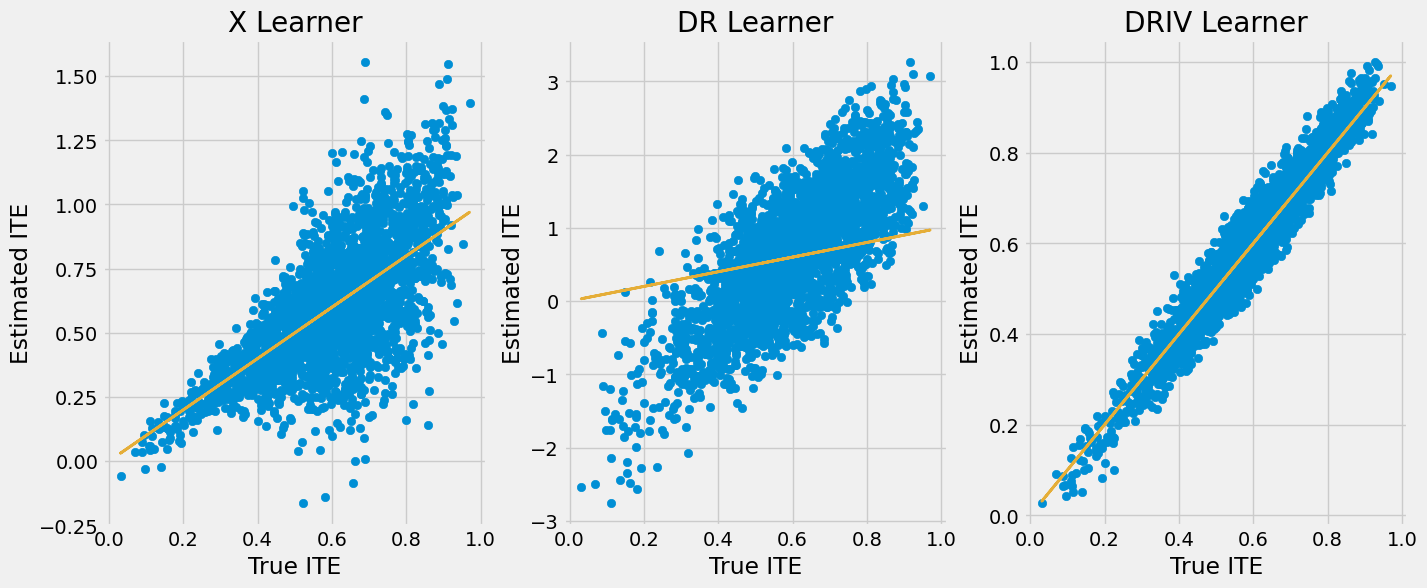

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].scatter(tau[treatment==1], cate_x[treatment==1])
ax[0].plot(tau[treatment==1], tau[treatment==1], color='C2', linewidth=2)
ax[0].set_xlabel('True ITE')
ax[0].set_ylabel('Estimated ITE')
ax[0].set_title('X Learner')
ax[1].scatter(tau[treatment==1], cate_dr[treatment==1])
ax[1].plot(tau[treatment==1], tau[treatment==1], color='C2', linewidth=2)
ax[1].set_xlabel('True ITE')
ax[1].set_ylabel('Estimated ITE')
ax[1].set_title('DR Learner')
ax[2].scatter(tau[treatment==1], cate_driv[treatment==1])
ax[2].plot(tau[treatment==1], tau[treatment==1], color='C2', linewidth=2)
ax[2].set_xlabel('True ITE')
ax[2].set_ylabel('Estimated ITE')
ax[2].set_title('DRIV Learner')

## DRIV 잔차와 Treatment 사이의 상관관계 확인 = 0.05

In [ ]:

y_pred_treated = learner_driv.models_mu_t[1][0].predict(X[treatment==1])   # treated group 예측값
y_pred_control = learner_driv.models_mu_c[1][0].predict(X[treatment==0])   # control group 예측값

# 실제 y
y_treated = y[treatment==1]
y_control = y[treatment==0]

# 잔차
residuals_treated = y_treated - y_pred_treated
residuals_control = y_control - y_pred_control

residuals = np.concat([residuals_treated, residuals_control])
treatment_reorderd = np.concat([treatment[treatment==1], treatment[treatment==0]])

np.corrcoef(treatment_reorderd, residuals) # 0.05


array([[1.        , 0.05565421],
       [0.05565421, 1.        ]])

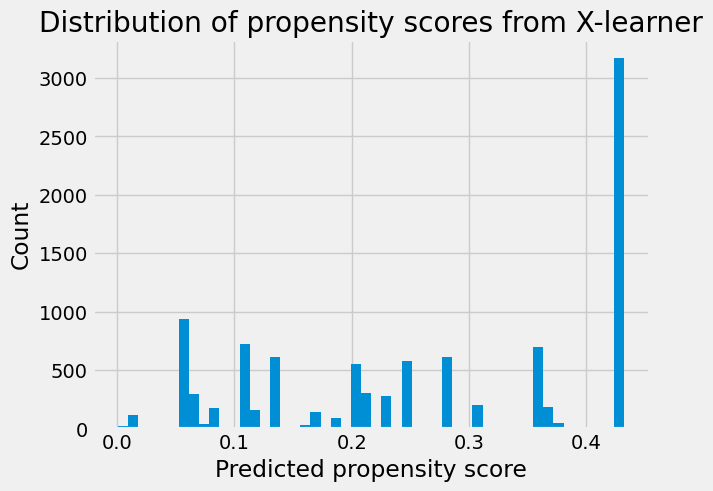

In [ ]:
propensity_scores = learner_x.propensity[1] # learner_dr.propensity_model[1].predict(X)  # 처리 확률
plt.hist(propensity_scores, bins=50)
plt.xlabel("Predicted propensity score")
plt.ylabel("Count")
plt.title("Distribution of propensity scores from X-learner")
plt.show()


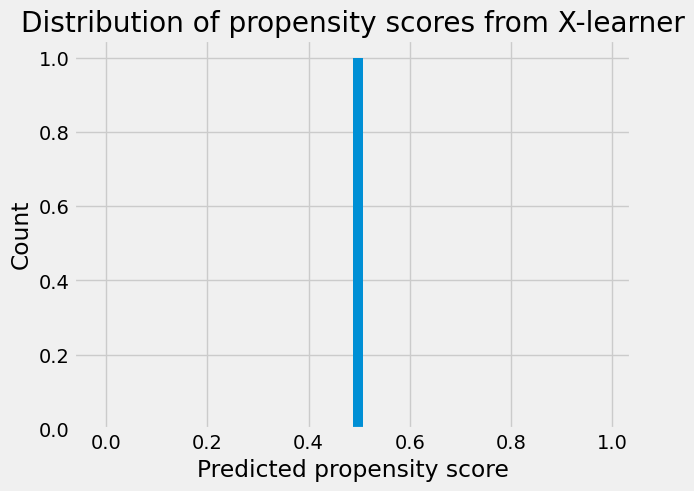

In [ ]:
propensity_scores = learner_driv.propensity_assign[1] # learner_dr.propensity_model[1].predict(X)  # 처리 확률
plt.hist(propensity_scores, bins=50)
plt.xlabel("Predicted propensity score")
plt.ylabel("Count")
plt.title("Distribution of propensity scores from X-learner")
plt.show()


# CollegeDistance 데이터 셋
교육이 임금에 미치는 영향을 분석하는 자료

## 문제:
교육 수준(education)이 임금(wage)에 미치는 영향을 알고 싶습니다.

## 선택편향:
사람들은 자신의 교육 수준을 무작위로 배정받는 것이 아니라, 스스로 선택합니다. 대학에 가기로 "선택"한 사람들은 그렇지 않은 사람들보다 원래부터 더 성실하거나, 재능이 뛰어나거나, 목표 의식이 높을 가능성이 있습니다.

(내생성은 회귀분석 모델에서 설명변수(X)가 오차항(ε)과 상관관계를 가질 때 발생하는 문제)

---
"성실함, 재능, 목표 의식"과 같은 관찰되지 않는 특성들이 바로 내생성 문제의 핵심입니다.

1. 이 특성들은 당연히 임금(wage)에 긍정적인 영향을 줄 것입니다. (이들은 회귀식의 오차항 ε에 포함됩니다.)

2. 동시에 이 특성들은 개인이 대학에 가기로 선택(education) 하는 데에도 영향을 미칩니다.

3. 결과적으로, 설명변수인 education이 오차항 ε에 포함된 "관찰되지 않는 특성"들과 상관관계를 갖게 됩니다. 즉, Cov(education, ε) ≠ 0 이 되어 내생성 문제가 발생하는 것입니다.


In [ ]:
import pandas as pd
data_url = "https://vincentarelbundock.github.io/Rdatasets/csv/AER/CollegeDistance.csv"
college_data = pd.read_csv(data_url)

In [ ]:
college_data

,rownames,gender,ethnicity,score,fcollege,mcollege,home,urban,unemp,wage,distance,tuition,education,income,region
0,1,male,other,39.150002,yes,no,yes,yes,6.2,8.09,0.2,0.88915,12,high,other
1,2,female,other,48.869999,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
2,3,male,other,48.740002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
3,4,male,afam,40.400002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
4,5,female,other,40.480000,no,no,no,yes,5.6,8.09,0.4,0.88915,13,low,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4734,9391,male,afam,56.529999,no,no,yes,no,6.6,8.89,0.8,0.25751,13,high,west
4735,9401,male,afam,59.770000,no,no,yes,no,6.6,8.89,0.8,0.25751,15,high,west
4736,9411,male,other,43.169998,no,no,yes,no,6.6,8.89,0.8,0.25751,12,high,west
4737,9421,male,afam,49.970001,yes,yes,yes,no,6.6,8.89,0.8,0.25751,16,high,west


- education	최종 학력 (교육 연수)
- wage	임금 (시간당)
- distance	거주지에서 가장 가까운 4년제 대학까지의 거리 (10마일 단위)
- gender	성별 (예: female, male)
- ethnicity	인종 (예: afam, hisp, other)
- score	고등학교 재학 중 치른 종합 시험 점수
- fcollege	아버지가 대학 졸업자인지 여부 (factor)
- mcollege	어머니가 대학 졸업자인지 여부 (factor)
- home	자가 거주 여부 (factor)
- urban	학교가 도시에 위치하는지 여부 (factor)
- unemp	1980년 기준 거주 카운티의 실업률
- tuition	주(state)의 평균 4년제 대학 등록금 (1000달러 단위)
- income	가구 소득이 $25,000를 초과하는지 여부 (factor)
- region	거주 지역 (예: west, other)